# MNIST CNN 分类

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np


## 1. 加载数据

In [3]:

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 归一化到 [-1,1]
])

# 加载训练和测试数据
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

class_names = [str(i) for i in range(10)]


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:01<00:00, 6980408.56it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 11223542.46it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 4394616.44it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2285332.15it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## 2. 定义 CNN 模型

In [4]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
print(model)


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 3. 定义损失函数和优化器

In [5]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 4. 训练模型

In [6]:

epochs = 5
train_losses, train_accs = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss/len(train_loader)
    epoch_acc = 100*correct/total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch 1/5, Loss: 0.1604, Accuracy: 95.12%
Epoch 2/5, Loss: 0.0449, Accuracy: 98.64%
Epoch 3/5, Loss: 0.0328, Accuracy: 98.97%
Epoch 4/5, Loss: 0.0223, Accuracy: 99.31%
Epoch 5/5, Loss: 0.0174, Accuracy: 99.45%


## 5. 测试集评估

In [7]:

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")


Test Accuracy: 98.69%


## 6. 可视化预测结果

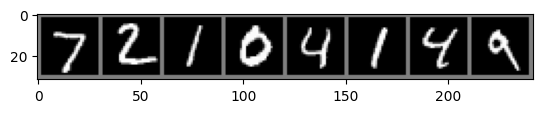

GroundTruth: ['7', '2', '1', '0', '4', '1', '4', '9']
Predicted  : ['7', '2', '1', '0', '4', '1', '4', '9']


In [8]:

def imshow(img):
    img = img / 2 + 0.5  # 反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# 获取一批测试数据
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 预测
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# 显示图像和预测结果
imshow(torchvision.utils.make_grid(images[:8]))
print("GroundTruth:", [class_names[labels[j]] for j in range(8)])
print("Predicted  :", [class_names[predicted[j]] for j in range(8)])


## 7. 可视化图片和对应标签

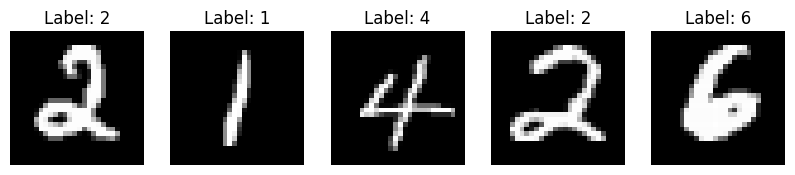

In [10]:
#在 PyTorch 里，MNIST 数据集通常是通过 torchvision.datasets.MNIST 加载的，不会直接生成 train_images、train_labels 变量，而是返回一个 Dataset 对象

import matplotlib.pyplot as plt

# 从数据集中取出一部分图片和标签
images, labels = next(iter(train_loader))

# 可视化前 5 张图片
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")  # squeeze 去掉通道维度
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.show()
